## Person Segmentation with Autoencoders ##

In [105]:
from torchvision import transforms

import torch
import matplotlib.pyplot as plt
import torch.optim as optim

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Data Pre-Processing ###

In [122]:
class PersonSegmentationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images_dir = os.path.join(data_dir, 'images')
        self.masks_dir = os.path.join(data_dir, 'masks')
        self.images = [f for f in os.listdir(self.images_dir) if f.endswith('.png')]
        self.masks = [f for f in os.listdir(self.masks_dir) if f.endswith('.png')]

        # Ensure that we have a mask for each image
        assert len(self.images) == len(self.masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.masks[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask
    
def show_image_and_mask(image, mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the image
    ax1.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    ax1.set_title('Image')
    ax1.axis('off')
    
    # Display the mask
    ax2.imshow(mask.squeeze(), cmap='gray')  # Remove the channel dimension
    ax2.set_title('Mask')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

In [158]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = PersonSegmentationDataset(data_dir='data', transform=transform)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create dataloaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


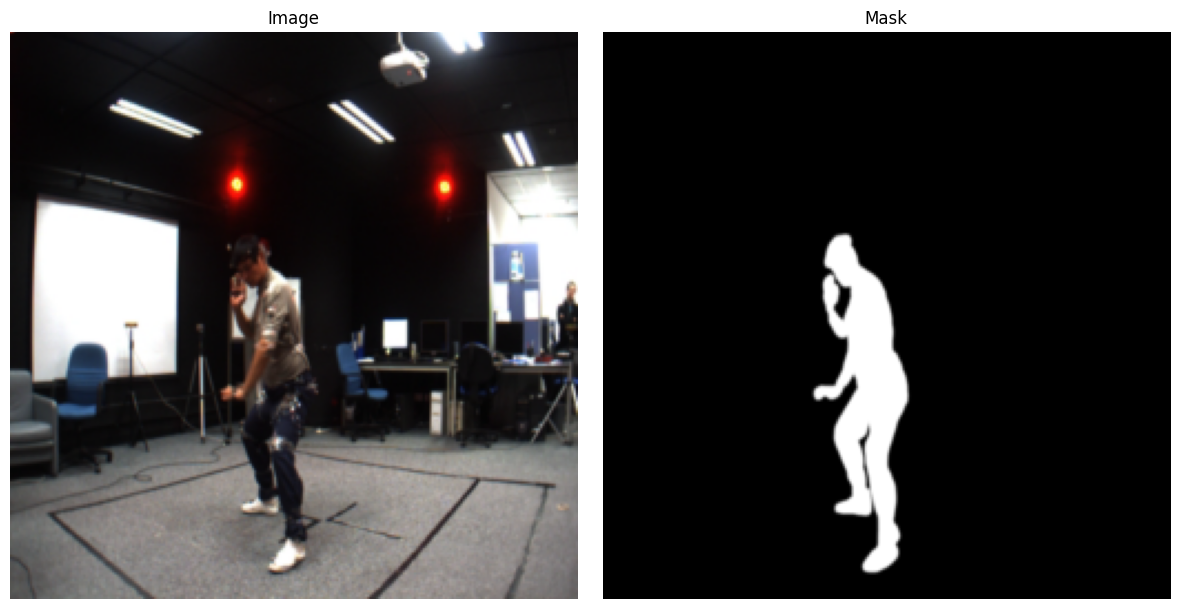

In [159]:
image, mask = train_dataset[0]  # Get the first image-mask pair
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

# Show the image and mask
show_image_and_mask(image, mask)


### Model Architecture ###

In [160]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3 , 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3,padding=1),
            ##nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # output is grayscale
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder()
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
num_epochs = 500
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    for batch_images, batch_masks in train_dataloader:
        batch_images, batch_masks = batch_images.to(device), batch_masks.to(device)
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_masks)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

### Evaluation ###

In [ ]:
with torch.no_grad():
    for images, masks in train_dataloader:    
            outputs = model(images)    
        # Visualize results for the first image in the batch
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(images[0].cpu().permute(1, 2, 0))
            axs[0].set_title('Input Image')
            axs[1].imshow(masks[0].cpu().squeeze())
            axs[1].set_title('Ground Truth')
            axs[2].imshow(outputs[0].cpu().squeeze())
            axs[2].set_title('Predicted Mask')
            plt.show()

In [ ]:
def iou_score(pred, target):
    pred = pred > 0.5  # Convert to binary mask
    target = target > 0.5
    intersection = (pred & target).float().sum()
    union = (pred | target).float().sum()
    return (intersection + 1e-6) / (union + 1e-6)

def dice_coefficient(pred, target):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred & target).float().sum()
    return (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

model.eval()
with torch.no_grad():
    total_iou = 0.0
    total_dice = 0.0
    num_samples = 0
    
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        
        # Calculate metrics
        iou = iou_score(outputs, masks)
        dice = dice_coefficient(outputs, masks)
        
        total_iou += iou.item() * images.size(0)
        total_dice += dice.item() * images.size(0)
        num_samples += images.size(0)
        
        # Visualize results for the first image in the batch
        if num_samples <= images.size(0):  # Only plot once
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(images[0].cpu().permute(1, 2, 0))
            axs[0].set_title('Input Image')
            axs[1].imshow(masks[0].cpu().squeeze())
            axs[1].set_title('Ground Truth')
            axs[2].imshow(outputs[0].cpu().squeeze())
            axs[2].set_title('Predicted Mask')
            plt.show()

    avg_iou = total_iou / num_samples
    avg_dice = total_dice / num_samples
    print(f'Average IoU: {avg_iou:.4f}, Average Dice: {avg_dice:.4f}')